In [ ]:
# Cell for possible istallation


# Semantic Segmentation of Airbus Ship Dataset with Unet (baseline)

In this notebook, we will build a baseline Unet model for semantic segmentation of the Airbus ship dataset.

## Importing the required libraries

In [ ]:
import numpy as np
import pandas as pd

from PIL import Image
import tensorflow as tf
import os
import sys
import random
import numpy as np

import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping
from keras import backend as keras

from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import glob
import skimage.io as io
import skimage.transform as trans
from tqdm import tqdm
from itertools import chain
from skimage.transform import resize
from skimage.io import imread, imshow


# Any results you write to the current directory are saved as output.
import os
os.listdir("/kaggle/input/airbus-ship-detection/")

Using TensorFlow backend.


['test_v2',
 'sample_submission_v2.csv',
 'train_ship_segmentations_v2.csv',
 'train_v2']

## Load the Data

In [ ]:
base_path="/kaggle/input/airbus-ship-detection/"
images_path="/kaggle/input/airbus-ship-detection/train_v2/"
df=pd.read_csv(base_path+"train_ship_segmentations_v2.csv")

# Pre-processing




In [ ]:
print("Total Images", len(df))
print("Images without masks",df.EncodedPixels.isnull().sum())
print("Images with mask" , len(df)-df.EncodedPixels.isnull().sum())
# x_train=X
df=df.dropna()
print("Total Images after droping nans", len(df))

# Adding full path of images to pandas dataFrame
df.ImageId=df.ImageId.apply(lambda x:images_path+x )

df.head()
# y_train=Y

print("splitting_dataframe into test train")


train_set = df.sample(frac=0.99, random_state=0)
test_set = df.drop(train_set.index)


print("Training DataFrame length ", len(train_set))
print("Testing DataFrame length ",len(test_set) )



Total Images 231723
Images without masks 150000
Images with mask 81723
Total Images after droping nans 81723
splitting_dataframe into test train
Training DataFrame length  80906
Testing DataFrame length  817


In [ ]:
def adjustData(img,mask):

    if(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0

    return (img,mask)

def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255



def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)


def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape) # Needed to align to RLE direction

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):

    for mask in in_mask_list:
        if isinstance(mask, str):

            all_masks += rle_decode(mask)

    return all_masks.T


In [ ]:

class_colors = [(random.randint(0, 255), random.randint(
    0, 255), random.randint(0, 255)) for _ in range(5000)]
def _get_colored_segmentation_image(img, seg, colors, n_classes):
    """ Return a colored segmented image """
    seg_img = np.zeros_like(seg)


    for c in range(n_classes):
        seg_img[:, :, 0] += ((seg[:, :, 0] == c) *
                            (colors[c][0])).astype('uint8')


    return img , seg_img


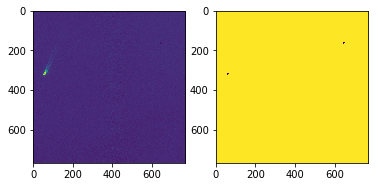

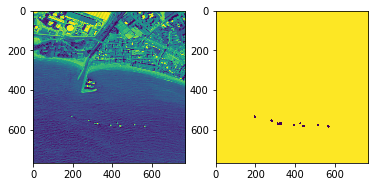

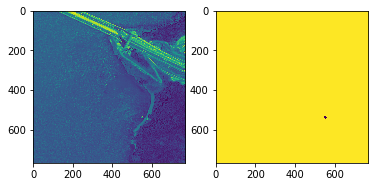

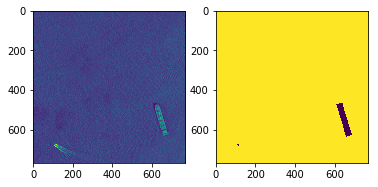

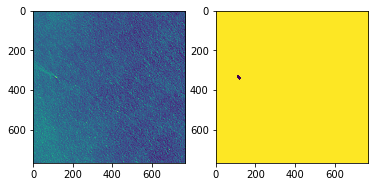

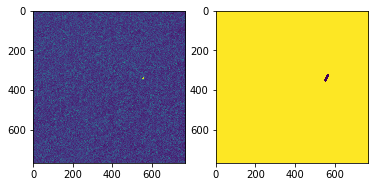

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import find_contours
from matplotlib.patches import Polygon
import cv2

batch_size=6
train_gen=iter(trainGenerator(train_set,num_class = 2,target_size = (768,768),batch_size=batch_size))
color =1# random_colors(2)
for i in range(batch_size):
    X,Y=next(train_gen)


    img , seg_img = _get_colored_segmentation_image(X[i],Y[i], class_colors, n_classes=1)
    fig, ax = plt.subplots(1,2)

    ax[0].imshow(img.reshape(768,768))
    ax[1].imshow(seg_img.reshape(768,768))

    plt.show()





## Metric

In [ ]:
# Dice coefficient
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

# Dice loss
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

## Generators

In [ ]:


def trainGenerator(df,num_class = 2,target_size = (768,768),batch_size=2):
    IMG_HEIGHT, IMG_WIDTH=target_size
    img_list=[]
    mask_list=[]
    while(1):
        #     for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
        for i in range (len(df)):
            img = imread(df['ImageId'].iloc[i], as_gray=True)


            img = img / 255
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

            mask=masks_as_image(df.query('ImageId=="'+df['ImageId'].iloc[i]+'"')['EncodedPixels'])


            img,mask = adjustData(img,mask)


            img_list.append(img.reshape(768,768,1))
            mask_list.append(mask.reshape(768,768,1))


            if i%batch_size==0 and i >=batch_size:
                yield (np.asarray(img_list),np.asarray(mask_list))
                del img_list,mask_list
                img_list=[]
                mask_list=[]

def testGenerator(df,target_size = (768,768),flag_multi_class = False,as_gray = True):
    IMG_HEIGHT, IMG_WIDTH=target_size
    for i in range (len(df)):
        img = imread(df['ImageId'].iloc[i], as_gray=True)
        img = img / 255
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

## Unet implementation

In [ ]:
def unet(pretrained_weights = None,input_size = (768,768,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics=[dice_coef])

    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

## Training the model

In [ ]:
epoch=50
batch_size=6




test=trainGenerator(test_set,batch_size)
train=trainGenerator(train_set,batch_size)
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane_{epoch:02d}_{val_dice_coef:.2f}.hdf5', monitor='val_dice_coef',verbose=1, save_best_only=True, mode='max')
ES=EarlyStopping(monitor='val_dice_coef', min_delta=0, patience=20, verbose=1, mode='max', baseline=None, restore_best_weights=False)
H=model.fit_generator(train,steps_per_epoch=100,
	validation_data=test,
	validation_steps=100,
	epochs=epoch,callbacks=[model_checkpoint,ES])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/50
100/100 [==============================] - 108s 1s/step - loss: 0.0781 - dice_coef: 0.0034 - val_loss: 0.0048 - val_dice_coef: 0.0012

Epoch 00001: saving model to unet_membrane_01_0.00.hdf5
Epoch 2/50
100/100 [==============================] - 90s 899ms/step - loss: 0.0485 - dice_coef: 0.0053 - val_loss: 0.0619 - val_dice_coef: 0.0057

Epoch 00002: saving model to unet_membrane_02_0.01.hdf5
Epoch 3/50
100/100 [==============================] - 90s 899ms/step - loss: 0.0398 - dice_coef: 0.0055 - val_loss: 0.0127 - val_dice_coef: 0.0032

Epoch 00003: saving model to unet_membrane_03_0.00.hdf5
Epoch 4/50
100/100 [==============================] - 90s 899ms/step - loss: 0.0542 - dice_coef: 0.0068 - val_loss: 0.0302 - val_dice_coef: 0.0040

Epoch 00004: saving model to unet_membrane_04_0.00.hdf5
Epoch 5/50
100/100 [==============================] - 90s 898ms/step - loss: 0.0382 - dice_coef: 0.0064 - val_loss: 0.0206 - val_dice_coef: 0.0047

Epoch 00005: saving model to unet_memb

## Plot the training and validation loss

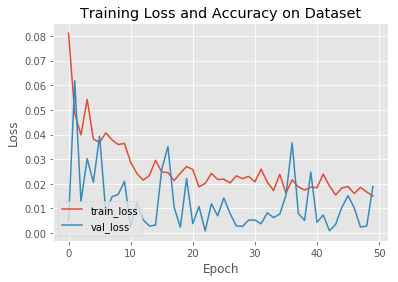

In [ ]:
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")

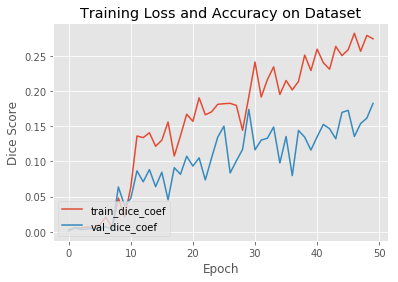

In [ ]:
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["dice_coef"], label="train_dice_coef")
plt.plot(np.arange(0, N), H.history["val_dice_coef"], label="val_dice_coef")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# Visuzlization of Images and masks

6/6 [==============================] - 1s 113ms/step


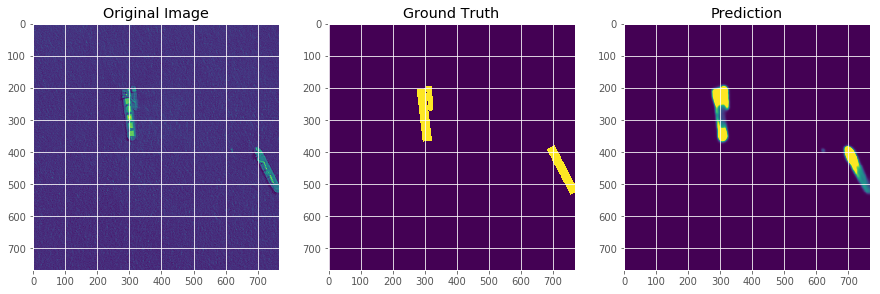

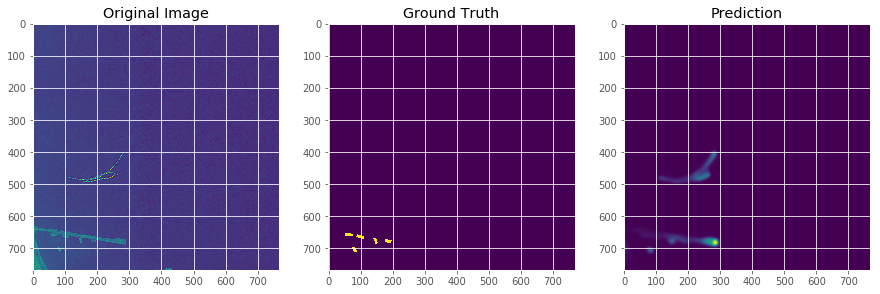

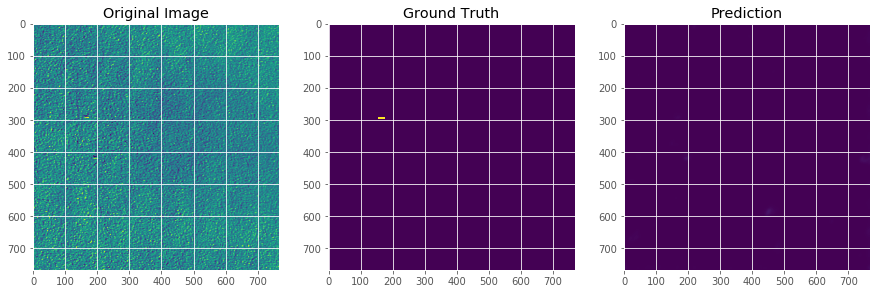

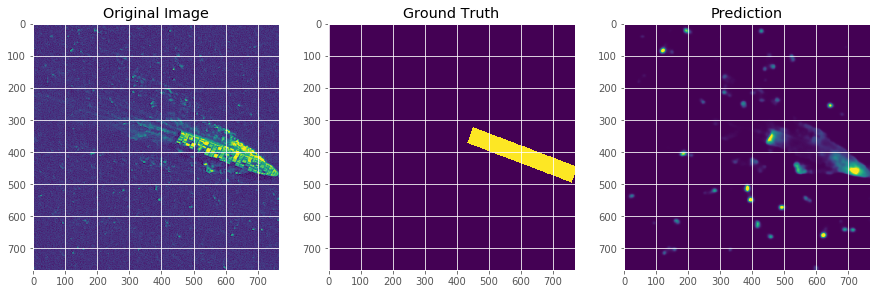

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

img_list = []
batch_size = 4

X, Y = next(train_gen, batch_size)

predict = model.predict(X, verbose=1)

for i in range(batch_size):
    plt.figure(figsize=(15, 5))

    # Plot Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(X[i].reshape(768, 768))
    plt.title('Original Image')

    # Plot Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(Y[i].reshape(768, 768))
    plt.title('Ground Truth')

    # Plot Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predict[i]))
    plt.title('Prediction')

    plt.show()


In [ ]:

predict = model.predict(X, verbose=1)


6/6 [==============================] - 1s 113ms/step


In [ ]:
predict.shape

(6, 768, 768, 1)

In [ ]:
import cv2
Encoded_points=[]
imgs=[]
path="/kaggle/input/airbus-ship-detection/test_v2/"
count=0
for i in os.listdir(path):
    if count==5:
        break
    img = cv2.imread(path+i,0)
    img = resize(img, (768,768), mode='constant', preserve_range=True)
    x=np.array(img)
    x=np.expand_dims(np.expand_dims(x, axis=0),axis=3)
    print(x.shape)
    predict = model.predict(x)
    predict = (predict > 0.5).astype(np.uint8)
    Encoded_points.append(np.squeeze(predict[0]))
    imgs.append(i)
    count=count+1

df=pd.DataFrame()
df["ImageId"]=imgs
df["EncodedPixels"]=Encoded_points


df.to_csv("results.csv")

(1, 768, 768, 1)
(1, 768, 768, 1)
(1, 768, 768, 1)
(1, 768, 768, 1)
(1, 768, 768, 1)


## How can we try to improve the model
Pretrain the encoder for classifying ships. And then do not change the encoder weights when training the segmentation model. Most powerful and popular pretrained encoders are MoveNet2 and ResNet50.

Use Data Augmentation for images with ships. Data augmentation is useful for training the model as it helps the model to learn more distinct features and patterns. Also it reduses overfitting.

We can also try to change the number of images without ships when training the model

We should also consider using original image shape (768 * 768 * 3) when training model for segmentation